In [46]:
from collections.abc import Iterable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


In [5]:
def ensure_iris_df(df: pd.DataFrame | None=None) -> pd.DataFrame:
    needed = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
    if df is None or not set(needed).issubset(df.columns):
        data = load_iris()
        df = pd.DataFrame(
            data=data.data,
            columns=['sepal-length', 'sepal-width', 'petal-length', 'petal-width']
        )
        df['class'] = data.target
    return df[needed].copy()

In [31]:
def choose_k_by_elbow(k_range: Iterable[int], inertias: list[float]) -> int:
    ks = np.array(list(k_range), dtype=float)
    ys = np.array(inertias, dtype=float)
    x1, y1 = ks[0], ys[0]
    x2, y2 = ks[-1], ys[-1]

    num = np.abs((y2 - y1) * ks - (x2 - x1) * ys + (x2 * y1 - y2 * x1))
    den = np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)
    distances = num / den

    best_idx = int(np.argmax(distances))
    return int(ks[best_idx])

In [6]:

def elbow_inertia(X: np.ndarray, k_range: Iterable[int], random_state: int=42) -> list[float]:
    inertias: list[float] = []
    for k in k_range:
        model = KMeans(n_clusters=k, random_state=random_state, n_init='auto')
        model.fit(X)
        inertias.append(model.inertia_)
    return inertias

In [7]:
df = ensure_iris_df()
feature_cols = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width']
X = df[feature_cols].values
y_true = df['class'].values

In [8]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
k_range_elbow = range(1, 11)
k_range_sil = range(2, 11)

In [11]:
inertias = elbow_inertia(X_scaled, k_range_elbow)

In [14]:
inertias

[250.06200865345474,
 114.80605147182254,
 73.19198434012038,
 64.86980074450312,
 48.787964656021074,
 39.173478539681746,
 36.183057100388105,
 29.977894977561736,
 27.015159438577612,
 22.306454625735014]

In [32]:
choose_k_by_elbow(k_range_elbow, inertias)

3

In [15]:
from collections.abc import Sequence


def plot_elbow(k_values: Sequence[int],inertias: Sequence[float], title: str='Elbow method for optional k' ) -> None:
    if len(k_values) != len(inertias):
        raise ValueError('k_values and inertias must have the same length.')

    fig, ax = plt.subplots(figsize=(12, 8), dpi=120)

    ax.plot(
        k_values,
        inertias,
        marker='o',
        color='tab:blue',
        linewidth=2,
        markersize=8
    )

    for k, inertia in zip(k_values, inertias):
        ax.annotate(
            text=f'{k}',
            xy=(k, inertia),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=9,
            color='white',
            ha='left',
            va='bottom',
            alpha=0.8
        )

    ax.set_title('title')
    ax.set_xlabel('k')
    ax.set_ylabel('inertia')

    ax.grid(True)

    plt.tight_layout()
    plt.show()

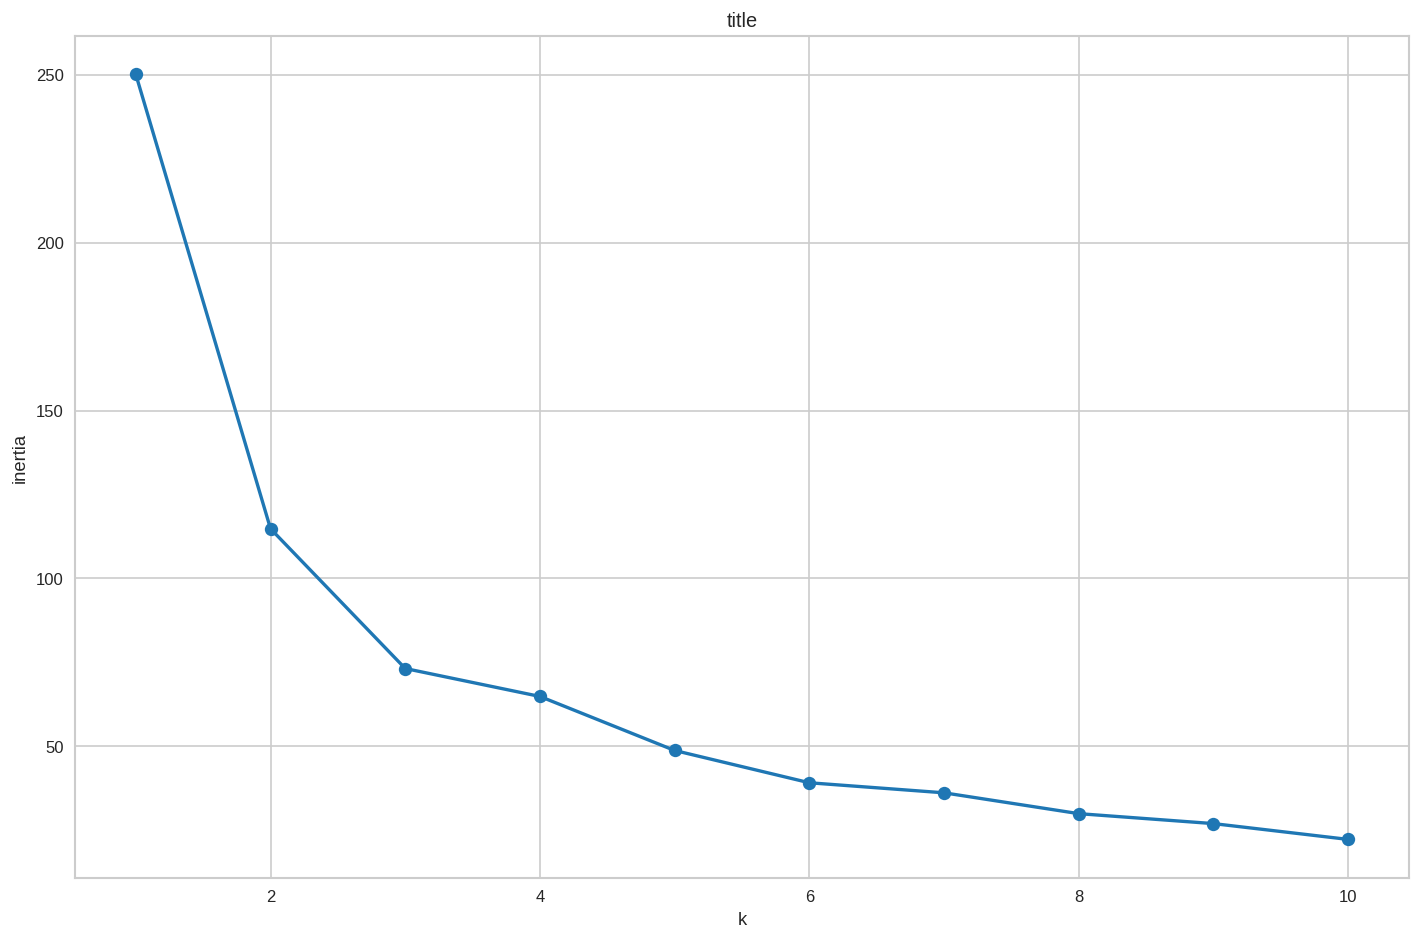

In [16]:
plot_elbow(k_range_elbow, inertias)

In [17]:


def plot_elbow_curve_with_annotation(
    k_values: Sequence[int],
    inertias: Sequence[float],
    title: str = "Elbow Method for Optimal k",
    figsize: tuple[int, int] = (8, 6),
    dpi: int = 120,
    color_line: str = "tab:blue",
    color_elbow: str = "tab:red",
    annotate_elbow: bool = True,
) -> int:
    """
    Plot an Elbow Curve for K-Means and (optionally) mark the detected 'elbow'.

    Parameters
    ----------
    k_values : Sequence[int]
        Range of k values tested.
    inertias : Sequence[float]
        Corresponding inertia (WSS) for each k.
    title : str, optional
        Title of the plot.
    figsize : tuple[int, int], optional
        Figure size in inches.
    dpi : int, optional
        Resolution of the figure.
    color_line : str, optional
        Color of the main line.
    color_elbow : str, optional
        Color used to highlight the detected elbow point.
    annotate_elbow : bool, optional
        Whether to display an annotation arrow for the elbow.

    Returns
    -------
    int
        The detected optimal number of clusters (elbow point).
    """
    if len(k_values) != len(inertias):
        raise ValueError("`k_values` and `inertias` must have the same length.")

    ks = np.array(list(k_values), dtype=float)
    ys = np.array(inertias, dtype=float)


    x1, y1 = ks[0], ys[0]
    x2, y2 = ks[-1], ys[-1]
    num = np.abs((y2 - y1) * ks - (x2 - x1) * ys + (x2 * y1 - y2 * x1))
    den = np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)
    distances = num / den
    elbow_idx = int(np.argmax(distances))
    elbow_k = int(ks[elbow_idx])


    plt.figure(figsize=figsize, dpi=dpi)
    plt.plot(ks, ys, marker="o", color=color_line, linewidth=2, markersize=7)
    plt.title(title, fontsize=14, weight="bold")
    plt.xlabel("Number of Clusters (k)", fontsize=12)
    plt.ylabel("Inertia (Within-cluster sum of squares)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)


    if annotate_elbow:
        plt.scatter(ks[elbow_idx], ys[elbow_idx], color=color_elbow, s=120, zorder=5)
        plt.annotate(
            text=f"Elbow at k={elbow_k}",
            xy=(ks[elbow_idx], ys[elbow_idx]),
            xytext=(20, 20),
            textcoords="offset points",
            fontsize=10,
            color=color_elbow,
            fontweight="bold",
            arrowprops=dict(
                arrowstyle="->",
                color=color_elbow,
                lw=1.5,
                shrinkA=0,
                shrinkB=5,
            ),
        )

    plt.tight_layout()
    plt.show()

    return elbow_k



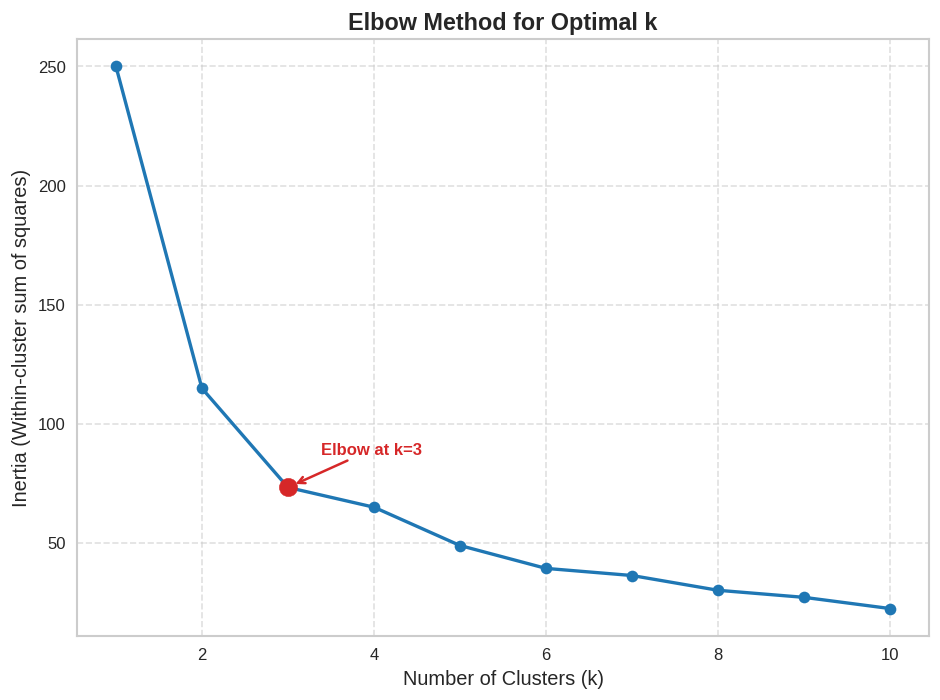

3

In [18]:
plot_elbow_curve_with_annotation(k_range_elbow, inertias)

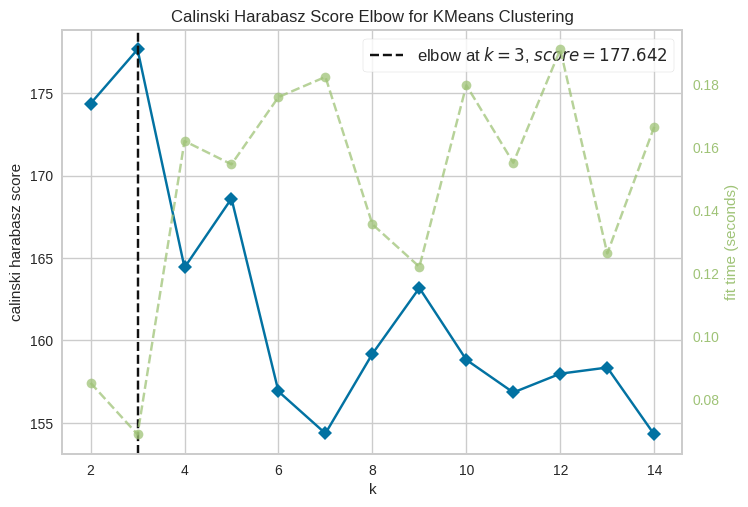

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [33]:
model_yellow = KMeans(n_clusters=3, random_state=42, n_init=10)
visualizer = KElbowVisualizer(model_yellow, k=(2, 15), metric='calinski_harabasz', force_model=True)
visualizer.fit(X_scaled)
visualizer.show()

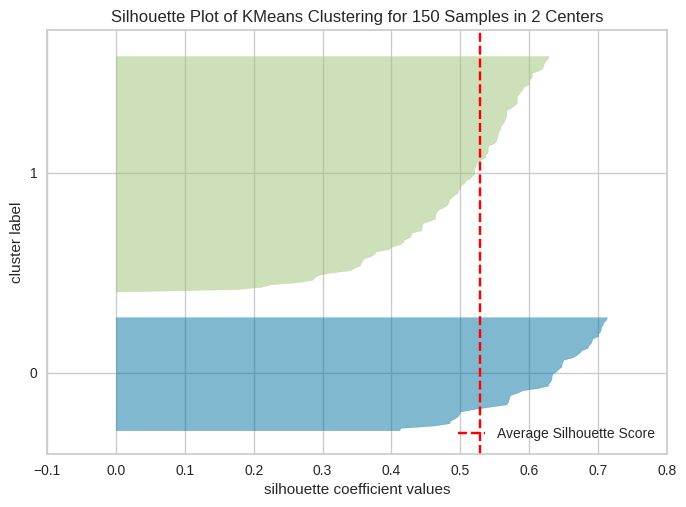

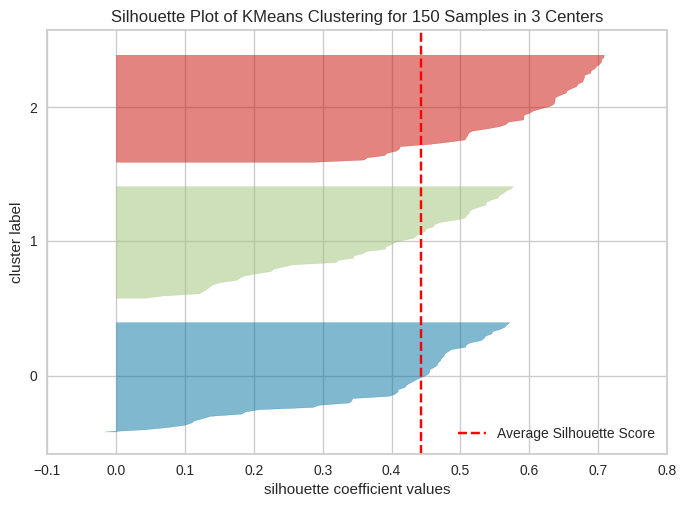

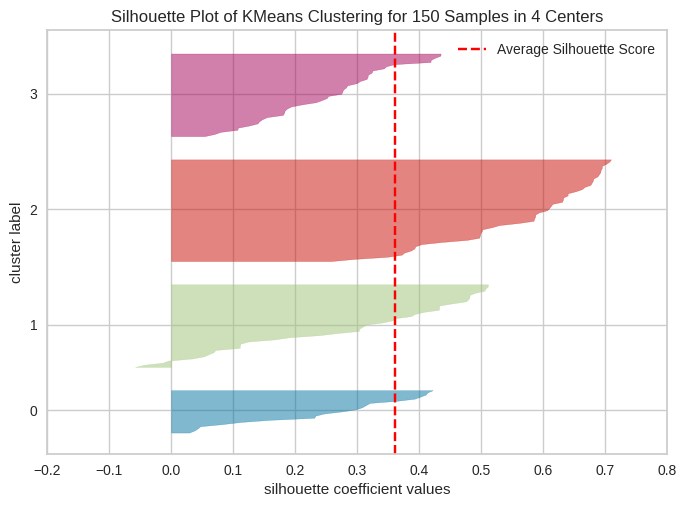

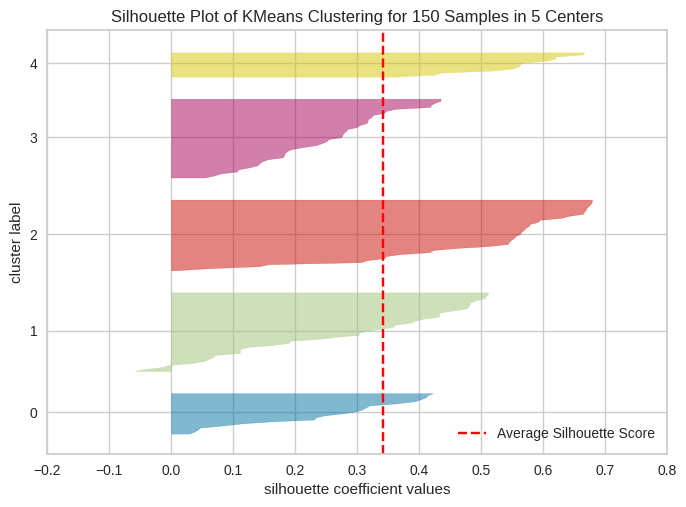

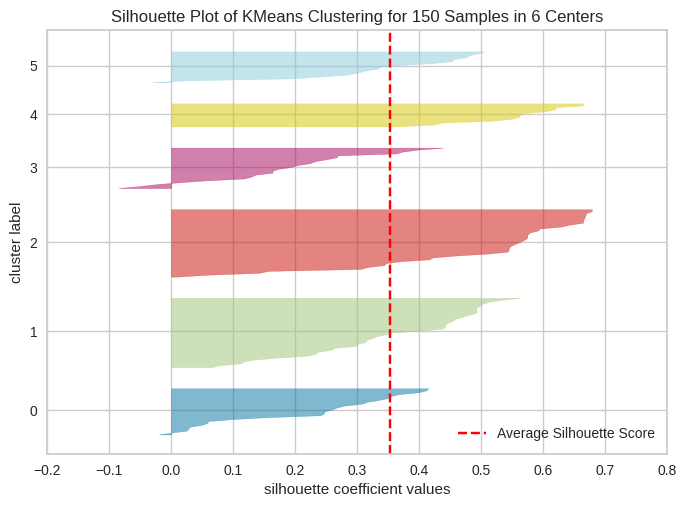

In [26]:
for k in range(2, 7):
    model_sil = KMeans(n_clusters=k, random_state=42, n_init='auto')
    visualizer = SilhouetteVisualizer(model_sil, colors='yellowbrick', force_model=True)
    visualizer.fit(X_scaled)
    visualizer.show()

In [27]:
def evaluate_clustering(true_labels, predicted_labels, data):
    """
    Evaluate and display key clustering performance metrics.

    Parameters
    ----------
    true_labels : array-like
        Ground truth class labels (used for external evaluation).
    predicted_labels : array-like
        Cluster labels assigned by the clustering algorithm.
    data : array-like, shape (n_samples, n_features)
        Original feature matrix, required for silhouette score.

    Returns
    -------
    dict
        Dictionary containing all calculated metrics.
    """

    scores = {
        "Homogeneity_score": metrics.homogeneity_score(true_labels, predicted_labels),
        "Completeness_score": metrics.completeness_score(true_labels, predicted_labels),
        "V_measure_score": metrics.v_measure_score(true_labels, predicted_labels),
        "Adjusted_rand_score": metrics.adjusted_rand_score(true_labels, predicted_labels),
        "Adjusted_mutual_info_score": metrics.adjusted_mutual_info_score(true_labels, predicted_labels),
        "Silhouette_score": metrics.silhouette_score(data, predicted_labels),
    }
    print("\n=== Clustering Evaluation Metrics ===")
    for name, value in scores.items():
        print(f"{name:30s}: {value:.4f}")

    return scores


In [30]:
for k in range(2, 7):
    model = KMeans(random_state=42, n_init='auto', n_clusters=k).fit(X)
    evaluate_clustering(y_true, model.labels_, X)


=== Clustering Evaluation Metrics ===
Homogeneity_score             : 0.5223
Completeness_score            : 0.8835
V_measure_score               : 0.6565
Adjusted_rand_score           : 0.5399
Adjusted_mutual_info_score    : 0.6538
Silhouette_score              : 0.6810

=== Clustering Evaluation Metrics ===
Homogeneity_score             : 0.7364
Completeness_score            : 0.7475
V_measure_score               : 0.7419
Adjusted_rand_score           : 0.7163
Adjusted_mutual_info_score    : 0.7387
Silhouette_score              : 0.5512

=== Clustering Evaluation Metrics ===
Homogeneity_score             : 0.7683
Completeness_score            : 0.6334
V_measure_score               : 0.6944
Adjusted_rand_score           : 0.5983
Adjusted_mutual_info_score    : 0.6891
Silhouette_score              : 0.4976

=== Clustering Evaluation Metrics ===
Homogeneity_score             : 0.8309
Completeness_score            : 0.6017
V_measure_score               : 0.6979
Adjusted_rand_score      

In [35]:
from sklearn.decomposition import PCA


def plot_clusters_in_pca_space(
        X: np.ndarray,
        labels: np.ndarray,
        kmeans: KMeans
) -> None:
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    centers_pca = pca.transform(kmeans.cluster_centers_)

    explained_var = pca.explained_variance_ratio_ * 100
    pc1_var, pc2_var = explained_var[:2]

    fig, ax = plt.subplots(figsize=(12, 8), dpi=120)
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.8, edgecolor='k', linewidths=0.3)
    ax.scatter(centers_pca[:, 0], centers_pca[:, 1], color='red', marker='X', s=200, alpha=0.8, edgecolor='k', linewidths=1.5, label='Cluster centroids')

    ax.set_title(f'Kmeans clusters (k={kmeans.n_clusters} in PCA space)')
    plt.tight_layout()
    plt.show()


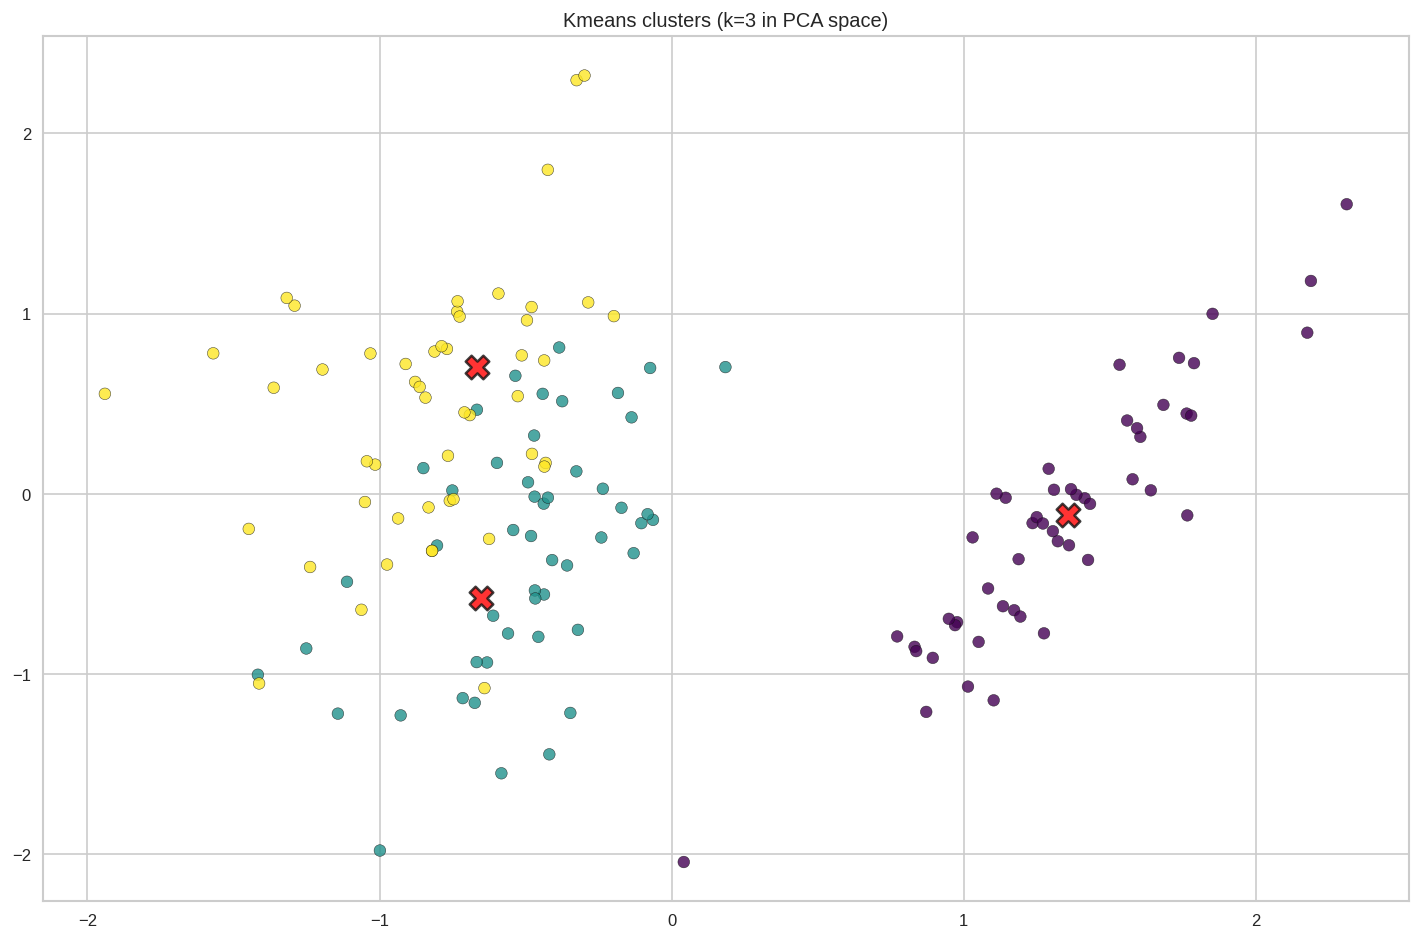

In [38]:
model = KMeans(random_state=42, n_init='auto', n_clusters=3).fit(X_scaled)
plot_clusters_in_pca_space(X_scaled, y_true, model)

In [42]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [41]:
model = KMeans(random_state=42, n_init='auto', n_clusters=3).fit(X_scaled)
model.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0], dtype=int32)

In [43]:
cm = confusion_matrix(model.labels_, y_true)
row_ind, col_ind = linear_sum_assignment(-cm)
list(zip(row_ind, col_ind))

[(np.int64(0), np.int64(2)),
 (np.int64(1), np.int64(1)),
 (np.int64(2), np.int64(0))]

In [44]:
cm_aligned = cm[:, col_ind]

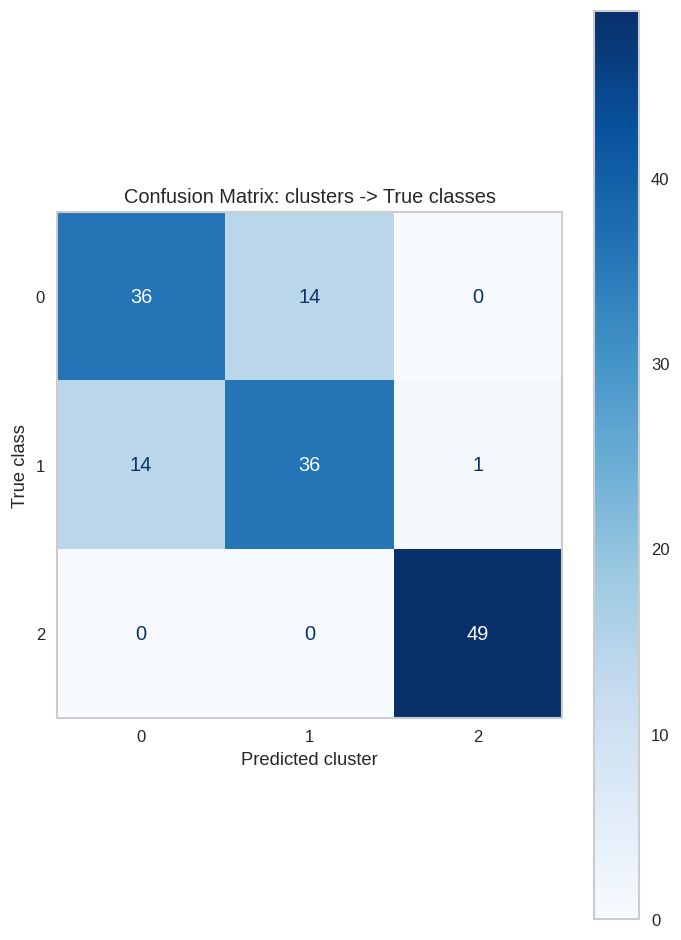

In [48]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_aligned)
fig, ax = plt.subplots(figsize=(6, 8), dpi=120)
disp.plot(ax=ax, cmap='Blues', colorbar=True)
ax.set_title('Confusion Matrix: clusters -> True classes')
ax.set_xlabel('Predicted cluster')
ax.set_ylabel('True class')

ax.grid(False)
plt.tight_layout()
plt.show()

In [49]:
def plot_confusion_matrix_aligned(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    class_names: list[str],
    normalize: bool = True,
    cmap: str = "Blues",
    figsize: tuple[int, int] = (6, 5),
    dpi: int = 120,
) -> None:
    """
    Display a confusion matrix for clustering results (e.g., KMeans),
    automatically aligning cluster labels to true classes using Hungarian algorithm.

    Parameters
    ----------
    y_true : np.ndarray
        True class labels.
    y_pred : np.ndarray
        Predicted cluster labels (from KMeans).
    class_names : list[str]
        List of true class names for axis labels.
    normalize : bool, default=True
        Normalize counts to show percentages per true class.
    cmap : str, default="Blues"
        Colormap for the confusion matrix.
    figsize : tuple[int, int], default=(6, 5)
        Figure size.
    dpi : int, default=120
        Resolution of the figure.
    """
    # --- compute confusion matrix ---
    cm = confusion_matrix(y_true, y_pred)

    # --- optimal mapping of clusters to true classes ---
    row_ind, col_ind = linear_sum_assignment(-cm)
    cm_aligned = cm[:, col_ind]

    # --- normalize (optional) ---
    if normalize:
        cm_aligned = cm_aligned.astype(float) / cm_aligned.sum(axis=1, keepdims=True)

    # --- compute accuracy ---
    accuracy = np.trace(cm_aligned) / np.sum(cm_aligned)
    print(f"Aligned clustering accuracy: {accuracy:.3f}")

    # --- display ---
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm_aligned,
        display_labels=class_names,
    )

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    disp.plot(cmap=cmap, ax=ax, colorbar=True)
    plt.title(f"Aligned Confusion Matrix (Accuracy = {accuracy:.2%})", fontsize=13, weight="bold")
    plt.xlabel("Predicted Cluster (Aligned)")
    plt.ylabel("True Class")
    plt.tight_layout()
    ax.grid(False)
    plt.show()

Aligned clustering accuracy: 0.807


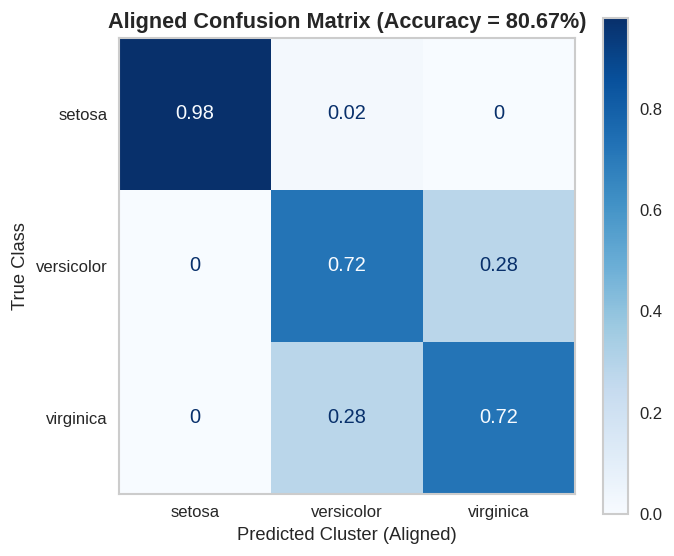

In [50]:
data = load_iris()
ax.grid(False)
plot_confusion_matrix_aligned(y_true, model.labels_, data.target_names.tolist())